# Summary
### Method:
- Data Selection:
    - Three different datasets, with missing values imputed by mean
    - First dataset consists only numeric data types, removing two features of timestamp and categorical; minimum feature engineering
    - Second dataset consists of 1)numeric data types 2) year, month, day extracted from timestamp column 3) one-hot encoded columns from categorical column
    - Third dataset consist of features picked primariliy with distinct value distribution difference between default and not default, comparing to rest of the features, such as features from var75 to var87
- Traing and Testing Split:
    - 80:20
- Hyperparamter:
    - random grids earch with narrow ranges to limit time spent on training
    - overall low iterations and low tuning
- Model selection:
    - Train each model with three different datasets
    - Random forest: 1) scoring method: f1-score 2) criterion: both gini and entropy 
    - Xgboost: 1) scoring method: roc_auc 2) objective: binary:logistic
- Evaluation:
    - confusion matrix, espeically precision and recall

### Result:
- Dataset:
    - shape: 52919 rows, 101 attributes
    - unbalanced: loan default consists of 9% of the data
    - missing values: 5 columns have more than 50% missing rate
    - multicollinearity: many columns are closely correlated with each other
    - target value distribution: certain features contains proportionaly more loan default than overall 9%
    - binary features: there are around 21 features that are binary
- Random Forest Training:
    - baseline model (with First dataset consists only numeric data types, removing two features of timestamp and categorical) 
        - best parameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
        - best f1-score:  0.2634
    - model with categorical data and time stamp data encoded(Second dataset consists of 1)numeric data types 2) year, month, day extracted from timestamp column 3) one-hot encoded columns from categorical column): 
        - best parameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
        - best f1-score:  0.2606
    - model with selected features (using var75 to var87):
        - best parameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
        - best f1-score:  0.1628
- Random Forest Evaluation:
    - baseline model: 
        - precision: 0.16
        - recall: 0.5
        - Top 3 features: var28, monthOriginated, loanNumber
    - model with categorical data and time stamp data encoded:
         - precision: 0.17
         - recall: 0.50
         - Top 3 features: var28, monthOriginated, loanNumber
    - model with selected features:
         - precision: 0.11
         - recall: 0.41
         - Top 3 features: var87, var86, var81
- Xgboost Training:
    - baseline model:
        - best parameter:  {'subsample': 0.5, 'scale_pos_weight': 6, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 1.0}
        - best f1-score:  0.2724
    - model with categorical data and time stamp data encoded:
        - best parameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
        - best f1-score:  0.2707
    - model with selected features:
        - best parameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
        - best f1-score:  0.07
- Xgboost Evaluation:
    - baseline model: 
        - precision: 0.21
        - recall: 0.40
        - Top 3 features: var28, var61, monthOriginated
    - model with categorical data and time stamp data encoded:
         - precision: 0.21
         - recall: 0.40
         - Top 3 features:  var28, var61, monthOriginated
    - model with selected features:
         - precision: 0.12
         - recall: 0.04
         - Top 3 features: var81, var84, var87



### Analysis:
- with limited tuning xgboost shows better precision than random forest
- with limited tuning, xgboost has a precision of 0.21, for the first two training set
- two features, loan numbers and month originated, display strong relationship in predicting default, indicating certain time period and order affected default 
- var28 is an important feature to predict default, and the value distribution indicates bivariate distribution
- var61 is another important feature to predict default, and the value distribution for two labels show different level of intensity, worth digging further

### Next steps:
- more hyperparater tuning: longer iteration, deeper trees
- more feature engineering: study each feature and explore potential features such as differences, or convert features into ordinal order
- deal with missing data more systematically by going through each column and impute by mean, median, mode, or by its neighbors
- consider drop features with high proportion of missing data, or to understand why they are missing, which could lead to more feature engineering to help modeling
- take care of high correlation between features, in case they contribute to overfitting for other modeling techniques

# Modeling Process
### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os 

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
plt.style.use('ggplot')
import seaborn as sns

import pickle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200) #display all the columns


C:\Users\samuelmao\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
original_df = pd.read_csv('modeling_challenge_data_2017.12.27.csv')

### Exploratory Data Analysis

In [119]:
# check data size
print("data shape: ", original_df.shape) #52919 rows, 101 attributes
# check data type and missing values
missing_total = original_df.isnull().sum()
observations_total = original_df.isnull().count()
missing_pct = (missing_total/observations_total) *100
missing_tb = pd.concat([missing_total,missing_pct], axis=1, keys = ['missing_counts','missing_pct'])
df_types = []
for col in original_df.columns:
    d_type = str(original_df[col].dtype)
    df_types.append(d_type)
missing_tb['data_types'] = df_types

print("\nData Type Breakdown: \n", missing_df.loc['data_types'].value_counts())
missing_df = np.transpose(missing_tb) 
missing_df

data shape:  (52918, 101)

Data Type Breakdown: 
 float64    58
int64      41
object      2
Name: data_types, dtype: int64


,loanNumber,monthOriginated,default,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90,var91,var92,var93,var94,var95,var96,var97,var98
missing_counts,0,0,0,0,299,0,0,1039,744,779,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1046,1860,305,0,127,1057,299,1915,1039,1039,1039,26917,39871,45338,720,40255,0,35095,1039,1039,1039,607,1039,1039,1039,1039,1039,607,2513,1039,1039,1039,0,0,313,1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,313,0,161,0,0,0,299,299,1039,1039,1039,1039,1039
missing_pct,0,0,0,0,0.565025,0,0,1.96342,1.40595,1.47209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00188972,0.00188972,0,0,0,1.97664,3.51487,0.576363,0,0.239994,1.99743,0.565025,3.61881,1.96342,1.96342,1.96342,50.8655,75.3449,85.676,1.3606,76.0705,0,66.3196,1.96342,1.96342,1.96342,1.14706,1.96342,1.96342,1.96342,1.96342,1.96342,1.14706,4.74886,1.96342,1.96342,1.96342,0,0,0.591481,1.97853,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.591481,0,0.304244,0,0,0,0.565025,0.565025,1.96342,1.96342,1.96342,1.96342,1.96342
data_types,int64,int64,int64,int64,float64,object,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64


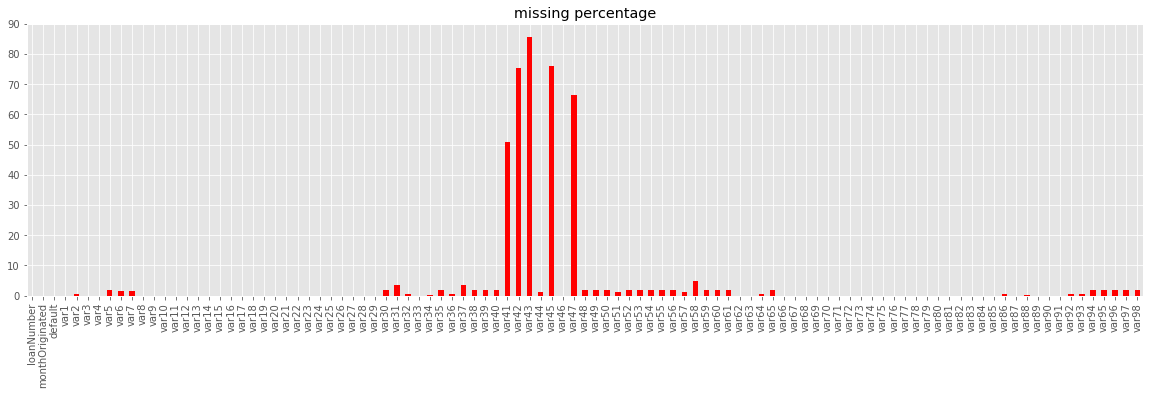

In [9]:
# visualize missing data for each columns
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
missing_df.loc['missing_pct',:].plot(kind='bar', color = 'r', title = 'missing percentage')
# column 41,42,43,45,47 have more than 50% missing values, should consider dropping

In [10]:
# check data stats
original_df.describe()
# data mean has large range
# it seems there are 

,loanNumber,monthOriginated,default,var1,var2,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90,var91,var92,var93,var94,var95,var96,var97,var98
count,52918.000000,52918.000000,52918.000000,52918.000000,52619.000000,5.291800e+04,51879.000000,52174.000000,52139.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.0,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52917.000000,52917.000000,52918.000000,52918.000000,52918.000000,51872.000000,51058.000000,52613.000000,52918.000000,52791.000000,51861.000000,52619.000000,51003.000000,51879.000000,51879.000000,51879.000000,26001.000000,13047.000000,7580.000000,52198.000000,12663.000000,52918.000000,17823.00000,51879.000000,51879.000000,51879.000000,52311.000000,51879.000000,51879.000000,51879.000000,51879.000000,51879.000000,52311.000000,50405.000000,51879.000000,51879.000000,51879.000000,52918.000000,52918.000000,52605.000000,51871.000000,52918.00000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.0,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52918.000000,52605.000000,5.291800e+04,52757.000000,52918.000000,52918.000000,52918.000000,5.261900e+04,52619.000000,5.187900e+04,5.187900e+04,51879.000000,5.187900e+04,5.187900e+04
mean,26459.500000,201446.631449,0.091198,0.005480,4.618731,8.144960e+04,15329.111240,9164.297945,66.485729,0.009467,0.013625,0.321535,6.715069,1305.739263,19.771409,6.182717,698.155694,694.155580,205.063929,0.0,0.587097,0.000019,0.000038,0.093617,0.319230,0.667026,0.060668,498.236737,0.161536,20327.798197,3.655959,35.458569,3.746168,0.282899,4.188763,0.905542,2.080693,132.803208,191.760423,13.876077,7.998786,33.608515,43.957768,71.688522,25.803192,39.239122,5.917646,35.20827,0.444573,3.925133,6.142408,4.941026,8.659650,9.306116,8.703946,15.570346,6.120897,12.344211,0.000635,0.003990,0.079300,2.087878,12.359292,0.482623,0.027588,94.888764,52.10387,-14.229719,0.083539,28.125346,0.180600,0.108432,0.005329,0.211629,0.653369,0.0,0.060584,0.003874,0.013946,0.005783,0.002627,0.031709,0.000378,0.008579,0.001455,0.000737,0.440771,2.029588e+04,58.439583,46.454477,0.047054,27.204713,5.776432e+04,23441.117752,4.718874e+04,3.584723e+04,178.984194,1.661558e+05,2.003850e+05
std,15276.255109,88.982428,0.287893,0.077814,3.076202,6.350256e+04,15747.599221,13505.183972,26.427349,0.108614,0.128161,0.864653,325.389225,2155.672462,8.341760,3.808184,28.739333,28.738736,85.240750,0.0,0.492360,0.004347,0.006148,0.291297,0.466183,0.958972,0.099858,191.491765,0.042604,7352.343518,27.765229,413.801272,39.540527,0.102002,101.716214,1.555015,2.157204,48.774059,89.546547,16.934073,8.896223,21.972268,22.142632,27.378441,31.778235,22.739089,6.013897,22.46891,1.195752,2.313581,3.429523,2.915273,4.760604,7.437483,4.566378,7.960150,3.384573,5.463520,0.025189,0.065736,0.451379,1.736143,5.468652,0.160085,0.063934,7.819733,35.09262,3420.290844,0.032436,9.800507,0.530047,0.338010,0.072806,0.408467,0.475901,0.0,0.238568,0.062121,0.117268,0.075823,0.051185,0.175227,0.019437,0.092227,0.038118,0.027138,0.549267,2.360522e+04,23.075478,41.849424,0.333253,11.768903,4.994096e+04,20910.281548,4.483767e+04,3.282418e+04,1993.890078,1.570253e+05,1.721624e+05
min,1.000000,201201.000000,0.000000,0.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1749.572048,0.000000,-1.000000,664.000000,66

In [11]:
# check potential binary data columns
print("There are {} columns that are likely to be binary".format((original_df.describe().loc['max',:] == 1).sum()))
#21 columns are likely to be binary

There are 21 columns that are likely to be binary


There are 9.12% target values label as 1, which is default


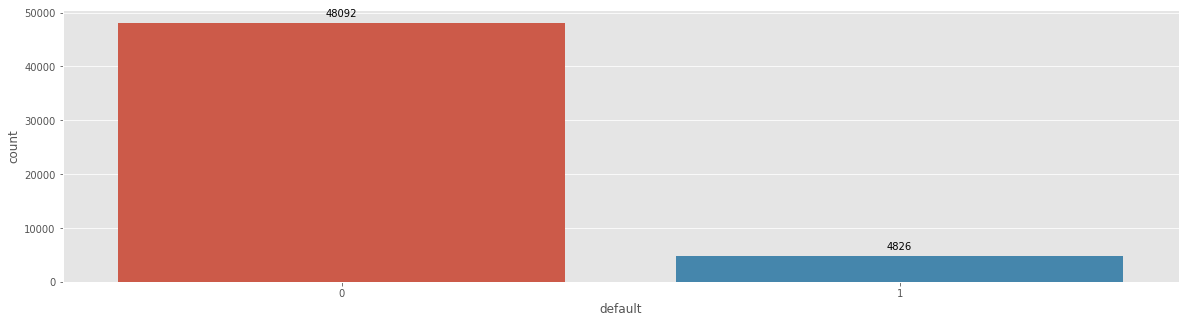

In [12]:
# check target value distribution
splot = sns.countplot(original_df['default'])
for p in splot.patches:
    splot.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
print("There are {0:.2f}% target values label as 1, which is default".format(100*original_df['default'].value_counts()[1]/original_df.shape[0]))
#about 9% are labeled as 1, which is default. Labels are unbalanced

In [14]:
# correlations between features
corr_df = original_df.corr().abs().unstack('correlation').sort_values().reset_index()
corr_df = corr_df.rename(columns={0:'correlation'})
corr_df = corr_df[corr_df['level_0'] != corr_df['level_1']]
np.transpose(corr_df.sort_values(ascending = False, by ='correlation')) 
# there are features with perfect correlation

,9314,9312,9305,9304,9303,9302,9301,9300,9299,9298,9297,9296,9295,9294,9293,9292,9290,9291,9288,9289,9287,9286,9285,9284,9282,9283,9281,9280,9279,9278,9277,9276,9275,9274,9272,9273,9270,9271,9269,9268,9267,9266,9264,9265,9263,9262,9261,9260,9259,9258,9257,9256,9254,9255,9253,9252,9251,9250,9249,9248,9247,9246,9245,9244,9243,9242,9241,9240,9239,9238,9236,9237,9234,9235,9233,9232,9231,9230,9228,9229,9227,9226,9225,9224,9223,9222,9221,9220,9218,9219,9217,9216,9215,9214,9213,9212,9211,9210,9209,9208,...,9700,9701,9702,9703,9704,9705,9706,9707,9708,9709,9710,9711,9712,9713,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723,9724,9725,9726,9727,9728,9729,9730,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741,9742,9743,9744,9745,9746,9747,9748,9749,9750,9751,9752,9753,9754,9755,9756,9757,9758,9759,9760,9761,9762,9763,9764,9765,9766,9767,9768,9769,9770,9771,9772,9773,9774,9775,9776,9777,9778,9779,9780,9781,9782,9783,9784,9785,9786,9787,9788,9789,9790,9791,9792,9793,9794,9795,9796,9797,9798,9799,9800
level_0,var32,var30,var16,var17,var57,var62,var56,var50,var97,var98,var68,var33,var29,var27,var13,var69,var4,var12,var38,var18,loanNumber,monthOriginated,var47,var45,var41,var47,var92,var94,var95,var87,var26,var25,var51,var49,var59,var1,var66,var7,var7,var88,var62,var54,var52,var55,var57,var54,var97,var5,var24,var20,var54,var56,var50,var54,var50,var49,var49,var56,var5,var98,var93,var6,var45,var41,var54,var55,var93,var95,var54,var51,var55,var91,var61,var2,var89,var15,var73,var74,var51,var52,var42,var41,var88,var66,var62,var91,var91,var57,var51,var50,var70,var90,var62,var56,var57,var56,var91,var53,var50,var62,...,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var75,var76,var76,var77,var77,var78,var78,var79,var79,var80,var80,var81,var81,var82,var82,var83,var83,var84,var84,var85,var85,var86,var86,var87,var87,var88,var88,var89,var89,var90,var90,var91,var91,var92,var92,var93,var93,var94,var94,var95,var95,var96,var96,var97,var97,var98,var98
level_1,var30,var32,var17,var16,var62,var57,var50,var56,var98,var97,var33,var68,var27,var29,var69,var13,var12,var4,var18,var38,monthOriginated,loanNumber,var45,var47,var47,var41,var94,var92,var87,var95,var25,var26,var49,var51,var1,var59,var7,var66,var88,var7,var54,var62,var55,var52,var54,var57,var5,var97,var20,var24,var56,var54,var54,var50,var49,var50,var56,var49,var98,var5,var6,var93,var41,var45,var55,var54,var95,var93,var51,var54,var91,var55,var2,var61,var15,var89,var74,var73,var52,var51,var41,var42,var66,var88,var91,var62,var57,var91,var50,var51,var90,var70,var56,var62,var56,var57,var53,var91,var62,var50,...,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90,var91,var92,var93,var94,var95,var96,var97,var98,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75,var19,var75
correlation,1,1,1,1,0.998948,0.998948,0.987425,0.987425,0.986637,0.986637,0.968451,0.968451,0.965115,0.965115,0.948668,0.948668,0.941098,0.941098,0.920068,0.920068,0.899636,0.899636,0.896235,0.896235,0.879734,0.879734,0.866559,0.866559,0.855397,0.855397,0.852365,0.852365,0.849784,0.849784,0.846448,0.846448,0.845081,0.845081,0.838656,0.838656,0.832132,0.832132,0.831859,0.831859,0.831483,0.831483,0.819474,0.819474,0.816549,0.816549,0.816329,0.816329,0.812775,0.812775,0.806462,0.806462,0.801269,0.801269,0.791415,0.791415,0.790977,0.790977,0.785447,0.7854

<Figure size 1440x360 with 0 Axes>

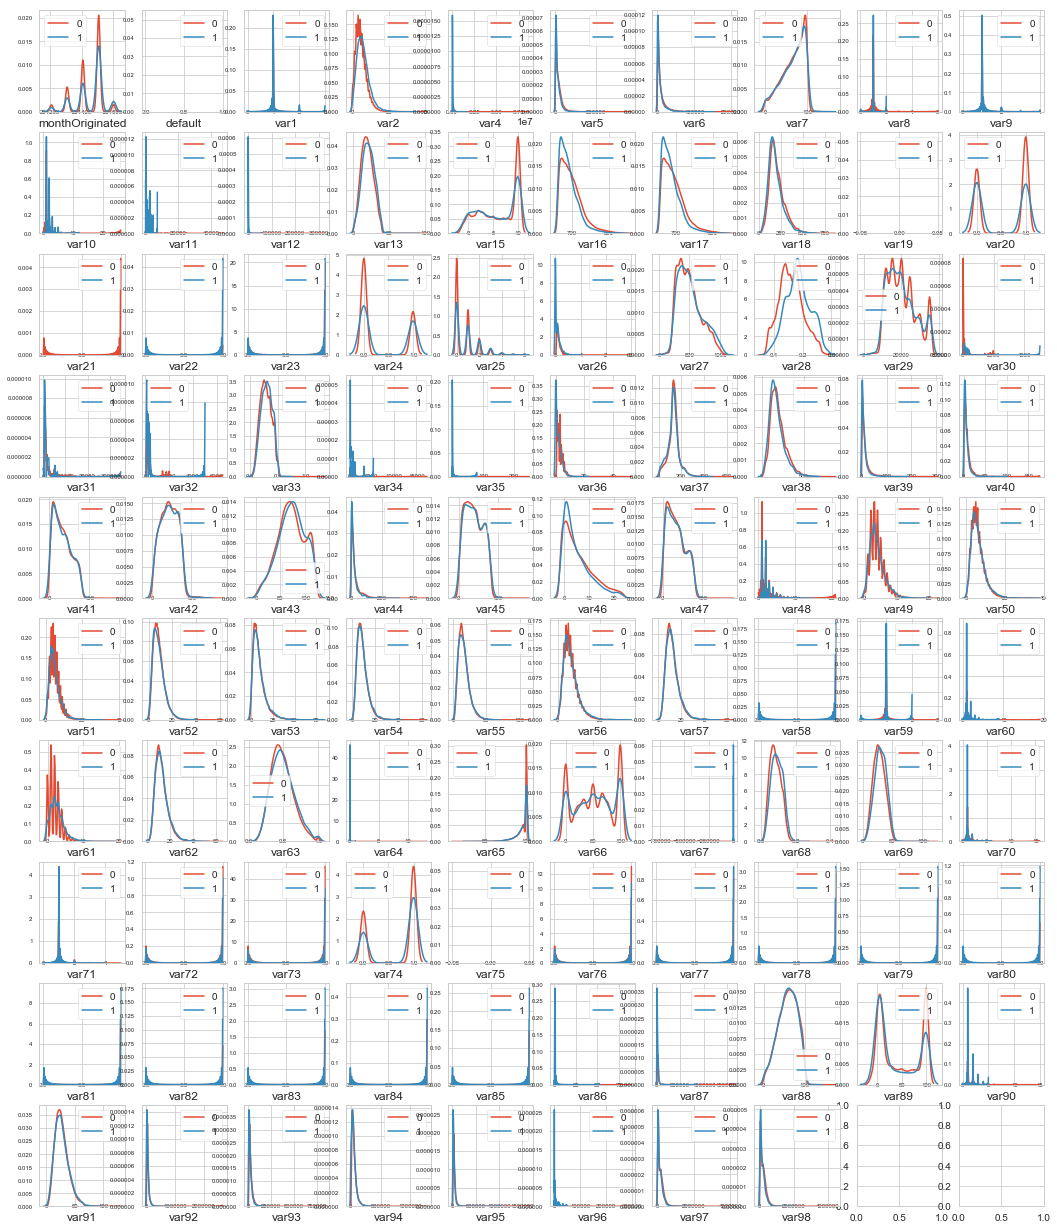

In [16]:
# create defaulted dataset for visualization
d0 = original_df.loc[original_df['default'] == 0] 
d1 = original_df.loc[original_df['default'] == 1]
# density plot of feature by each target value
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(10,10,figsize=(18,22))
for j in range(1,original_df.shape[1]):
    if original_df[original_df.columns[j]].dtypes != 'O':
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(d0[d0.columns[j]], hist= False, label = '0')
        sns.distplot(d1[d1.columns[j]], hist= False, label = '1')

        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
plt.show()

<Figure size 1440x360 with 0 Axes>

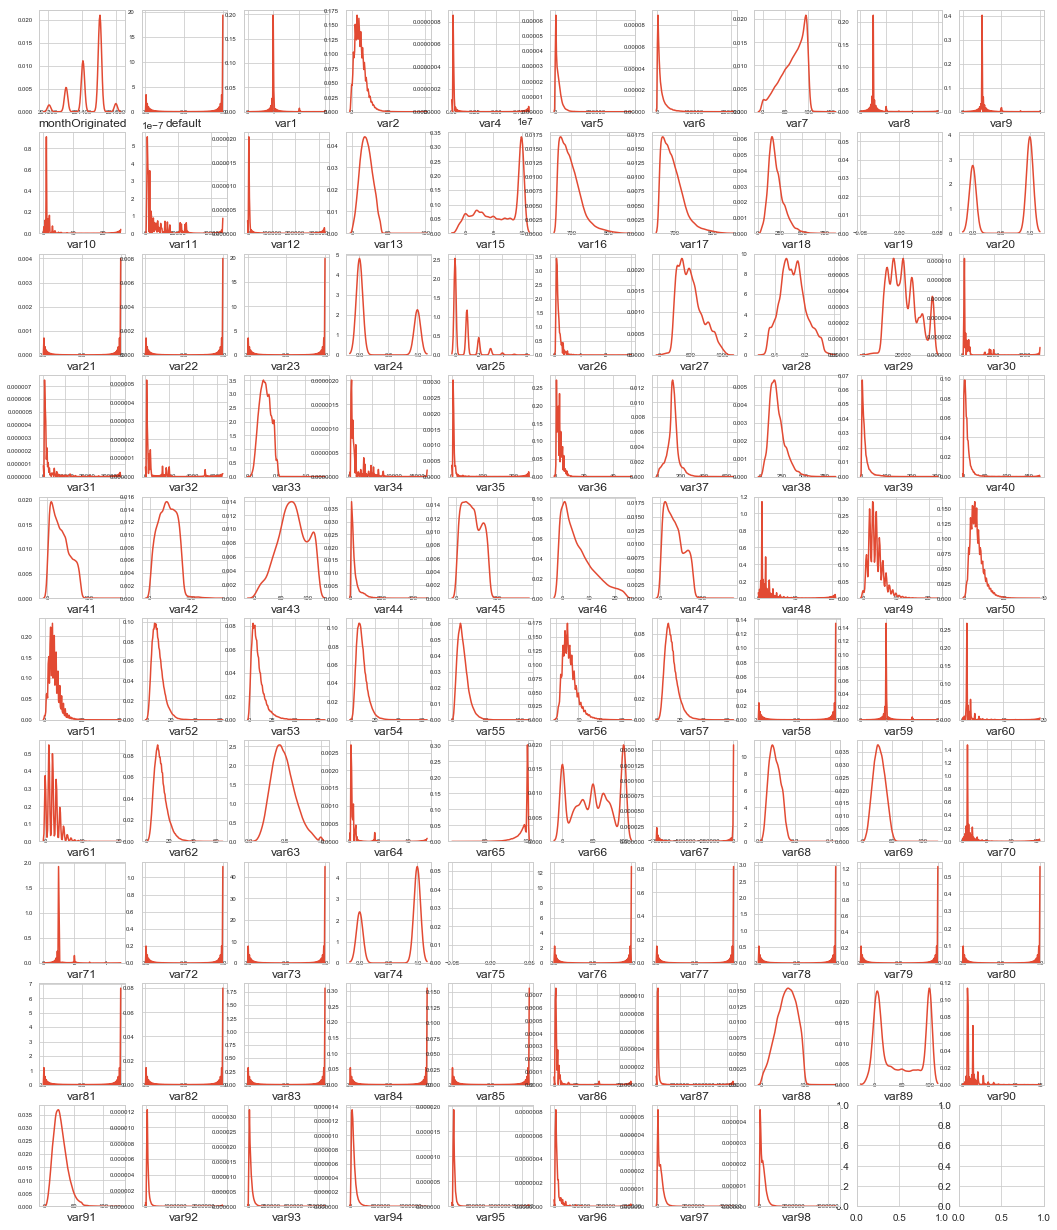

In [17]:
# density plots of each feature
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(10,10,figsize=(18,22))
for j in range(1,original_df.shape[1]):
    if original_df[original_df.columns[j]].dtypes != 'O':
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(original_df[original_df.columns[j]], hist= False)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
plt.show()

### Create Training and Testing Dataset

#### Training and Testing Data For Baseline Model

In [19]:
### divide into training and testing
# impute by mean
def impute_by_mean(original_df):
    numeric_features = original_df.columns[original_df.dtypes != 'O']
    fill_by_mean_df = original_df[numeric_features].fillna(original_df[numeric_features].mean())
    X = fill_by_mean_df.loc[:, fill_by_mean_df.columns != 'default']
    y = fill_by_mean_df['default']
    return(X,y)

X, y = impute_by_mean(original_df)
# create training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check split ratio
print("y_test split ratio: ",y_test.sum()/y_test.count())

y_test split ratio:  0.09117535903250189


#### Training and Testing Data with Hot-encoding var3 and Feature-engineering for var14

In [20]:
### divide into training and testing
# impute by mean, one-hot encoding for var3, extract year, month,date from var14

# make a copy of the data
original_df_encoded = original_df[::] 
cat_features = original_df_encoded.columns[original_df.dtypes == 'O']

original_df_encoded['var14'] = pd.to_datetime(original_df_encoded['var14'] )


In [21]:
# one-hot encoding var3 and join back to the dataframe
original_df_encoded = pd.concat([original_df_encoded, pd.get_dummies(original_df_encoded['var3'], drop_first = True)], join='outer', sort=True, axis=1)

In [22]:
original_df_encoded['var14_month'] = original_df_encoded['var14'].dt.month
original_df_encoded['var14_year'] = original_df_encoded['var14'].dt.year
original_df_encoded['var14_day'] = original_df_encoded['var14'].dt.day
original_df_encoded = original_df_encoded.drop(columns = ['var3','var14'])

In [72]:
# impute by mean
X_encoded, y_encoded = impute_by_mean(original_df_encoded)
# create training and testing data
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y)
#check split ratio
print("y_test split ratio: ",y_test_encoded.sum()/y_test_encoded.count())

y_test split ratio:  0.09117535903250189


#### Training and Testing Data with Selected Features: var75 to var87

In [121]:
### divide into training and testing
# keep only columns var 75 -87, as they have more people who defaulted. could be features very predictive

# make a copy of the data
df_var7587 = original_df[::] 

beg = df_var7587.columns.get_loc('var75')
end = df_var7587.columns.get_loc('var87')

df_var7587 = df_var7587.iloc[:,beg:end +1]
df_var7587 = pd.concat([original_df['default'], df_var7587], join='outer', sort=True, axis=1)

In [125]:
df_var7587['default'].value_counts()

0    48092
1     4826
Name: default, dtype: int64

In [62]:
# impute by mean
X_var7587, y_var7587 = impute_by_mean(df_var7587)
# create training and testing data
X_train_var7587, X_test_var7587, y_train_var7587, y_test_var7587 = train_test_split(X_var7587, y_var7587, test_size=0.2, random_state=42, stratify=y)
# check split ratio
print("y_test split ratio: ",y_test_var7587.sum()/y_test_var7587.count())

y_test split ratio:  0.09117535903250189


### Model: Random Forest

#### Create Parameter

In [66]:
# create model
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score
    
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
class_weight = 'balanced'
# Create the random grid
random_grid_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               "criterion": ["gini", "entropy"]
                }
print('random_grid_param', random_grid_param)

rfc = RandomForestClassifier(class_weight = 'balanced')
#n_iter: Number of parameter settings that are sampled
scoring_method = 'f1' #'roc_auc'


random_grid = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid_param, 
                               n_iter = 3, 
                               scoring = scoring_method, 
                               cv = 3, 
                               verbose=4, 
                               random_state=42, 
                               n_jobs = -1)

random_grid_param {'n_estimators': [200, 250, 300, 350, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


#### Fit Baseline Model

In [26]:
# Fit model
filename = 'rfc_fillbymean_model.sav'
random_grid.fit(X_train, y_train)
# save model
pickle.dump(random_grid, open(filename, 'wb'))

print("best_param: ", random_grid.best_params_)
print("best_score: ", random_grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  4.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.6min finished


best_param:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
best_score:  0.26344786328753866


#### Evaluate Baseline Model

          predicted 0  predicted 1
actual 0         7189         2430
actual 1          486          479
             precision    recall  f1-score   support

          0       0.94      0.75      0.83      9619
          1       0.16      0.50      0.25       965

avg / total       0.87      0.72      0.78     10584



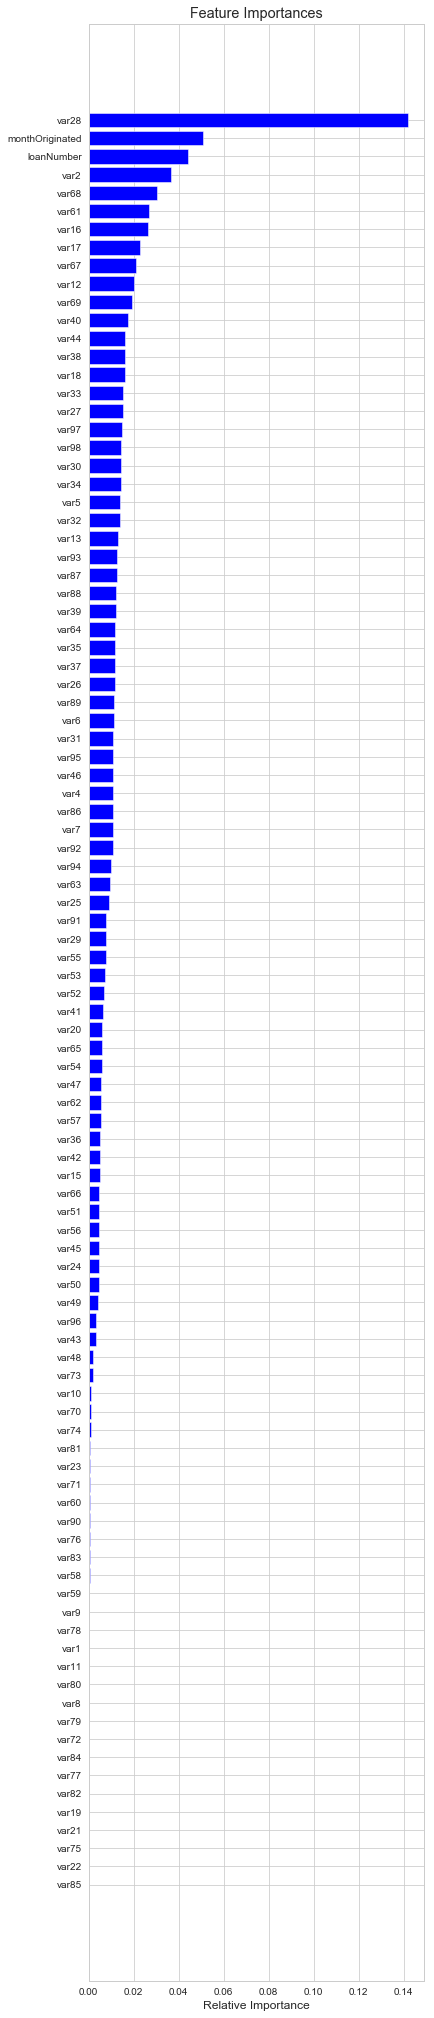

In [106]:
# evaluate result
# load model
filename = 'rfc_fillbymean_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#create confusion matrix
cm = confusion_matrix(y_test, loaded_model.predict(X_test))
cm_df = pd.DataFrame(cm,columns=['predicted 0','predicted 1'], index=['actual 0', 'actual 1'])
print(cm_df)
# create classification report
print(classification_report(y_true = y_test, y_pred = loaded_model.predict(X_test)))
# plot feature import
def plot_feature_importance(X_test, loaded_model):
    plt.rcParams['figure.figsize'] = (6.0, 36.0)
    features= X_test.columns
    importances = loaded_model.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')

plot_feature_importance(X_test, loaded_model)

#### Fit Model With Encoded Data

In [28]:
# Fit model with encoded data
# Fit model
filename = 'rfc_fillbymean_encoded_model.sav'

random_grid.fit(X_train_encoded, y_train_encoded)
# save model
pickle.dump(random_grid, open(filename, 'wb'))

print("best_param: ", random_grid.best_params_)
print("best_score: ", random_grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  4.0min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.0min finished


best_param:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
best_score:  0.26068764211168727


#### Evaluate Model With Encoded Data

          predicted 0  predicted 1
actual 0         7245         2374
actual 1          485          480
             precision    recall  f1-score   support

          0       0.94      0.75      0.84      9619
          1       0.17      0.50      0.25       965

avg / total       0.87      0.73      0.78     10584



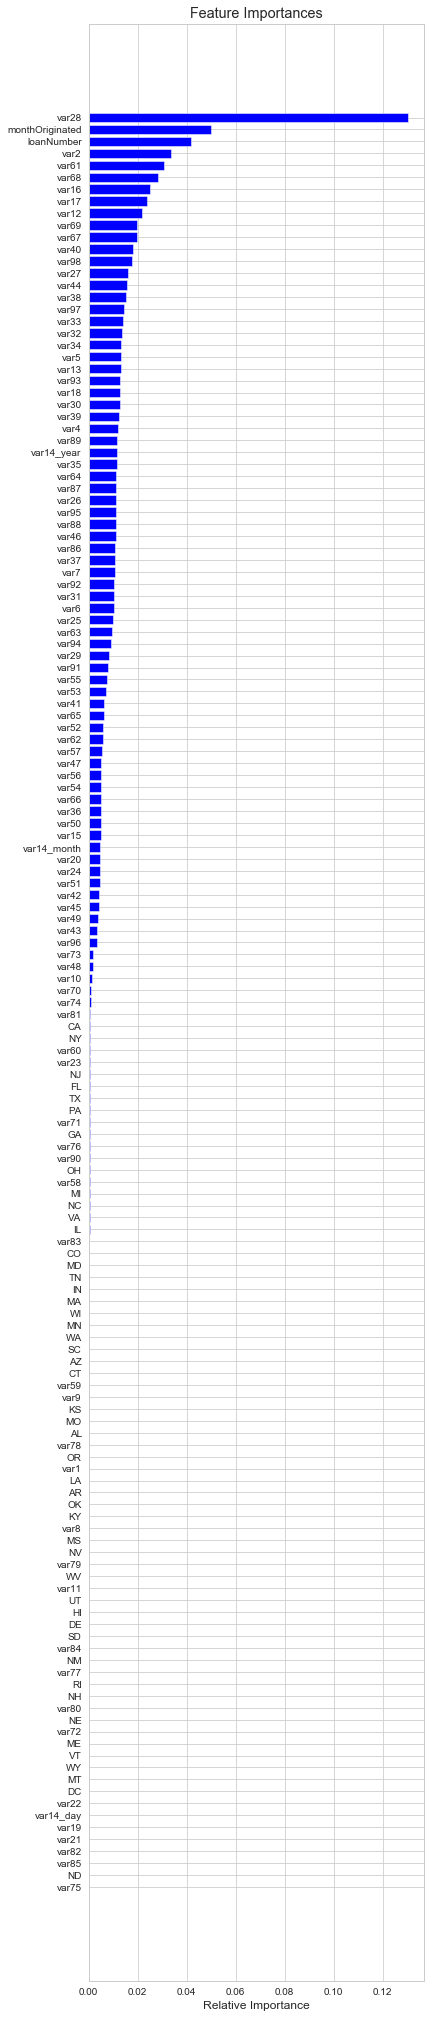

In [105]:
# evaluate result
# load model
filename = 'rfc_fillbymean_encoded_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# confusion matrix
cm = confusion_matrix(y_test_encoded, loaded_model.predict(X_test_encoded))
cm_df = pd.DataFrame(cm,columns=['predicted 0','predicted 1'], index=['actual 0', 'actual 1'])
print(cm_df)
# classification report
print(classification_report(y_true = y_test_encoded, y_pred = loaded_model.predict(X_test_encoded)))
# feature importance
plot_feature_importance(X_test_encoded, loaded_model)

#### Fit Model With Selected Features

In [67]:
# Fit var7587 model
filename = 'rfc_fillbymean_var7587_model.sav'
# fit model
random_grid.fit(X_train_var7587, y_train_var7587)
#save model
pickle.dump(random_grid, open(filename, 'wb'))

print("best_param: ", random_grid.best_params_)
print("best_score: ", random_grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  1.1min remaining:   55.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  4.0min finished


best_param:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}
best_score:  0.16289866596506342


#### Evaluate Model With Selected Features

          predicted 0  predicted 1
actual 0         6546         3073
actual 1          572          393
             precision    recall  f1-score   support

          0       0.92      0.68      0.78      9619
          1       0.11      0.41      0.18       965

avg / total       0.85      0.66      0.73     10584



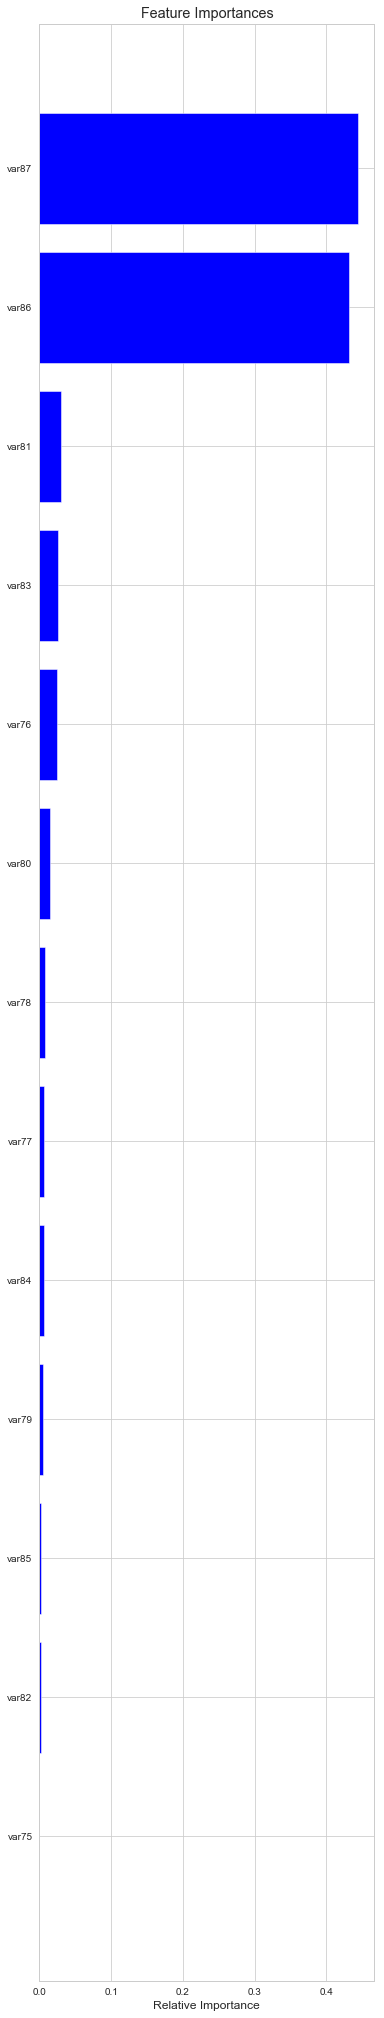

In [107]:
# evaluate result
# load model
filename = 'rfc_fillbymean_var7587_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#confusion matrix
cm = confusion_matrix(y_test_var7587, loaded_model.predict(X_test_var7587))
cm_df = pd.DataFrame(cm,columns=['predicted 0','predicted 1'], index=['actual 0', 'actual 1'])
print(cm_df)
# classification report
print(classification_report(y_true = y_test_var7587, y_pred = loaded_model.predict(X_test_var7587)))
#plot feature importance
plot_feature_importance(X_test_var7587, loaded_model)

### Model: Xgboost

#### Create Parameter

In [92]:
#n_estimators: number of trees
#eta: learning rate
#gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
#subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2],
        'subsample': [0.5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5],
        'scale_pos_weight': [5,6] 
        }

xgb = XGBClassifier(learning_rate= 0.2, n_estimators=50, objective='binary:logistic')

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=3, scoring='f1', n_jobs=-1, cv=3, verbose=3, random_state=100000 )

#### Fit Baseline Model

In [93]:
filename = 'xgb_fillbymeanmodel.sav'
# fit model
random_search.fit(X_train, y_train)
# save model
pickle.dump(random_search, open(filename, 'wb'))

print("best_param: ", random_search.best_params_)
print("best_score: ", random_search.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   46.8s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.0min finished


best_param:  {'subsample': 0.5, 'scale_pos_weight': 6, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 1.0}
best_score:  0.2724307803563189


#### Evaluate Baseline Model

          predicted 0  predicted 1
actual 0         8165         1454
actual 1          583          382
             precision    recall  f1-score   support

          0       0.93      0.85      0.89      9619
          1       0.21      0.40      0.27       965

avg / total       0.87      0.81      0.83     10584



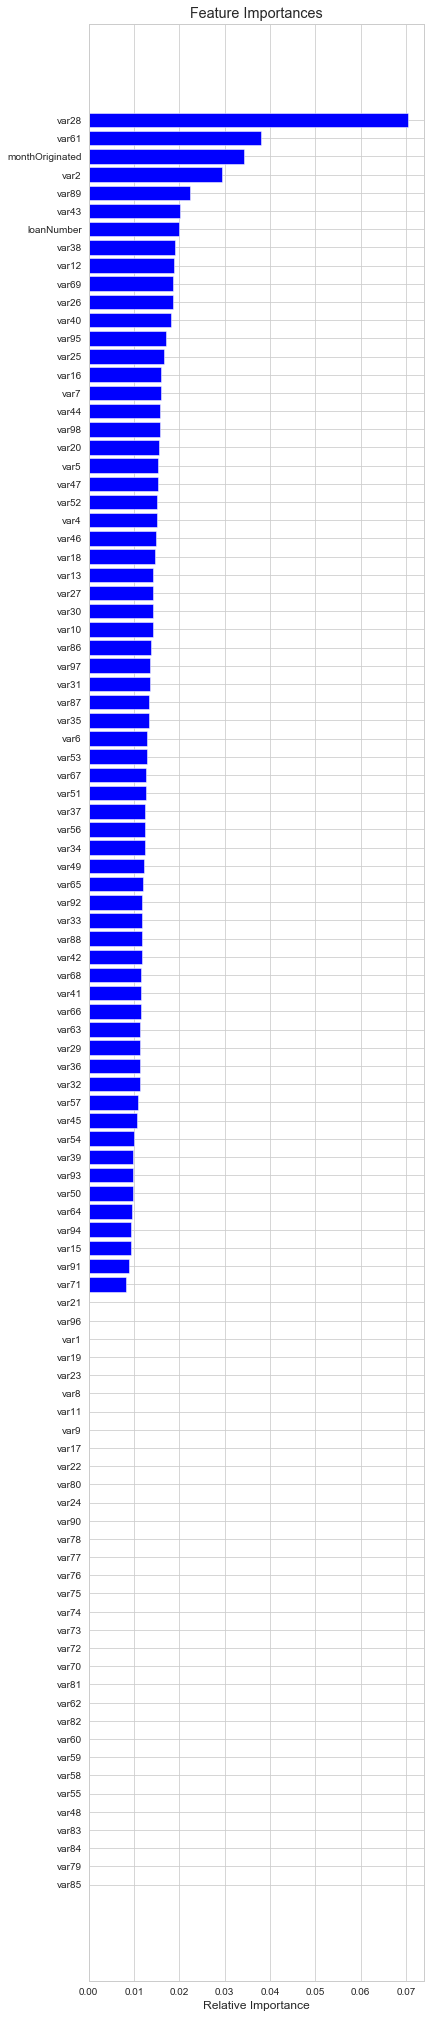

In [109]:
# evaluate result
# load model
filename =  'xgb_fillbymeanmodel.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# confusion matrix
cm = confusion_matrix(y_test, loaded_model.predict(X_test))
cm_df = pd.DataFrame(cm,columns=['predicted 0','predicted 1'], index=['actual 0', 'actual 1'])
print(cm_df)
# classification report
print(classification_report(y_true = y_test, y_pred = loaded_model.predict(X_test)))
#plot feature importance
plot_feature_importance(X_test, loaded_model)

#### Fit Model With Encoded Data

In [95]:
# run encoded data
filename = 'xgb_fillbymeanmodel_encoded.sav'
# fit model
random_search.fit(X_train_encoded, y_train_encoded)
# save model
pickle.dump(random_search, open(filename, 'wb'))

print("best_param: ", random_search.best_params_)
print("best_score: ", random_search.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.0min remaining:   30.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.4min finished


best_param:  {'subsample': 0.5, 'scale_pos_weight': 6, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 1.0}
best_score:  0.2707300613549088


#### Evaluate Model With Encoded Data

          predicted 0  predicted 1
actual 0         8157         1462
actual 1          580          385
             precision    recall  f1-score   support

          0       0.93      0.85      0.89      9619
          1       0.21      0.40      0.27       965

avg / total       0.87      0.81      0.83     10584



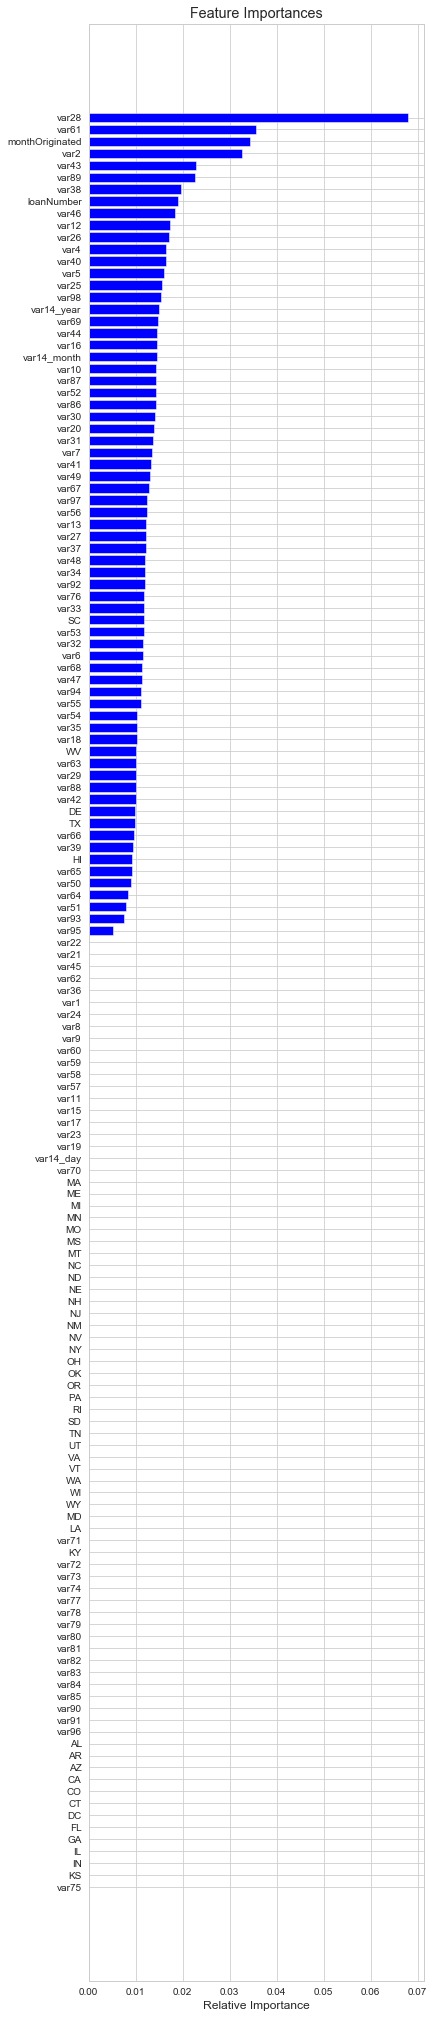

In [110]:
# evaluate result
# load model
filename =  'xgb_fillbymeanmodel_encoded.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# confusion matrix
cm = confusion_matrix(y_test_encoded, loaded_model.predict(X_test_encoded))
cm_df = pd.DataFrame(cm,columns=['predicted 0','predicted 1'], index=['actual 0', 'actual 1'])
print(cm_df)
# classification report
print(classification_report(y_true = y_test_encoded, y_pred = loaded_model.predict(X_test_encoded)))
#plot feature importance
plot_feature_importance(X_test_encoded, loaded_model)

#### Fit Model With Selected Features

In [97]:
# run var7587 data
filename = 'xgb_fillbymeanmodel_var7587.sav'
# fit model
random_search.fit(X_train_var7587, y_train_var7587)
#save model
pickle.dump(random_search, open(filename, 'wb'))

print("best_param: ", random_search.best_params_)
print("best_score: ", random_search.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   11.2s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   14.6s finished


best_param:  {'subsample': 0.5, 'scale_pos_weight': 6, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.6}
best_score:  0.07373270856075924


#### Evaluate Model With Encoded Data


          predicted 0  predicted 1
actual 0         9294          325
actual 1          922           43
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      9619
          1       0.12      0.04      0.06       965

avg / total       0.84      0.88      0.86     10584



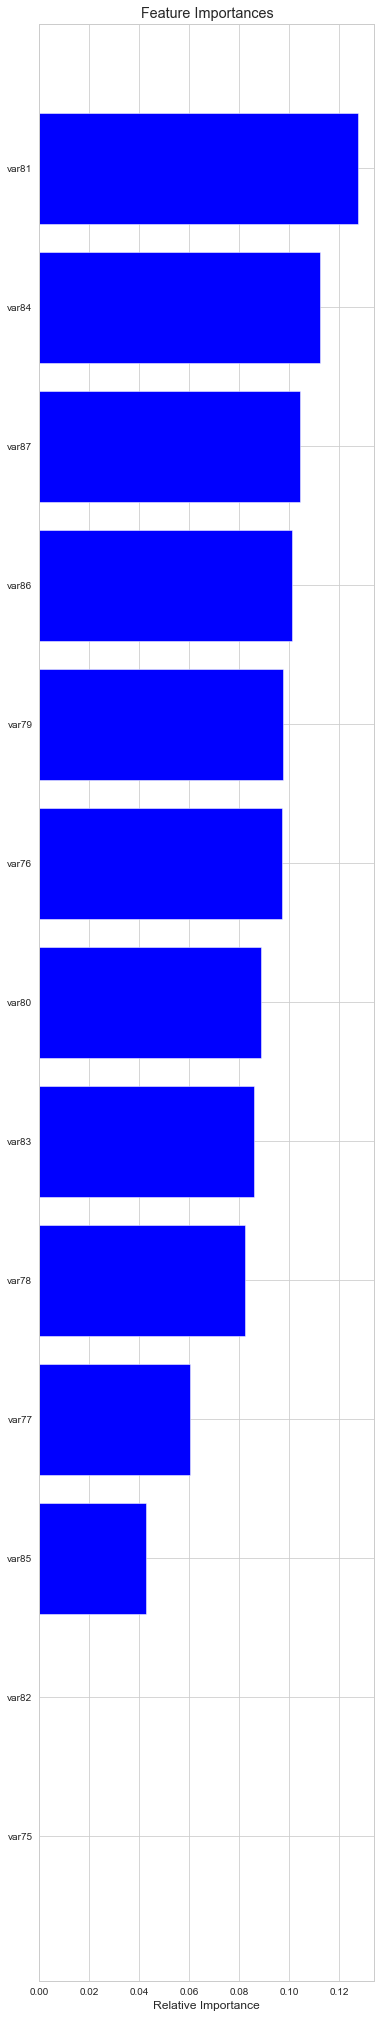

In [111]:
# evaluate result
filename =  'xgb_fillbymeanmodel_var7587.sav'
loaded_model = pickle.load(open(filename, 'rb'))
# create confustion matrix
cm = confusion_matrix(y_test_var7587, loaded_model.predict(X_test_var7587))
cm_df = pd.DataFrame(cm,columns=['predicted 0','predicted 1'], index=['actual 0', 'actual 1'])
print(cm_df)
#create classification report
print(classification_report(y_true = y_test_var7587, y_pred = loaded_model.predict(X_test_var7587)))
#plot feature importance
plot_feature_importance(X_test_var7587, loaded_model)

In [38]:
# understand the parameters
# write recommendations